* first of all i have to say i used some parts of [https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard](http://) for this kernal (including boxcox transformation and tuning hyper parameters in modeling sections.
so thank u @serigne!
the perpouse of this kernal is not having the most accurate model.i just want to give you a blue print about what you should do for regression problems 

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.width', 1000)

In [5]:
train = pd.read_csv(r'C:\Users\Talion\Desktop\DataSciencesProjects\house price predictions\3. uploaded data/train.csv')
test = pd.read_csv(r'C:\Users\Talion\Desktop\DataSciencesProjects\house price predictions\3. uploaded data/test.csv')


In [6]:
train.corr()['SalePrice'].sort_values(ascending=False).head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

lets quickly take a peek at some most important attributes:

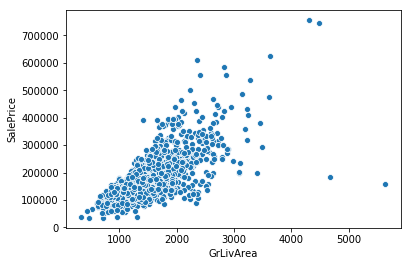

In [7]:
sns.scatterplot(train['GrLivArea'],train['SalePrice'])

# outliers:

Identifies extreme values in data

Outliers are defined as:
Values below Q1-1.5(Q3-Q1) or above Q3+1.5(Q3-Q1)

In [8]:
def find_outliers_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1   
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])

    return outlier_indices
out=find_outliers_tukey(train['TotalBsmtSF'])

In [9]:
train=train.drop(out)

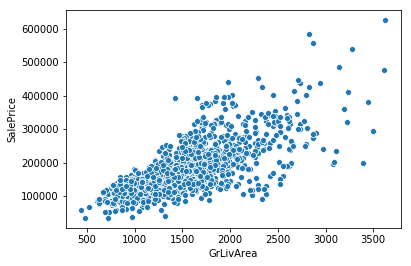

In [10]:
#take another look:
sns.scatterplot(train['GrLivArea'],train['SalePrice'])

thats much better!

C:\Users\Talion\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


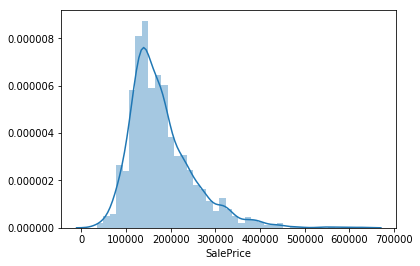

In [11]:
sns.distplot((train['SalePrice']))

log transormation:

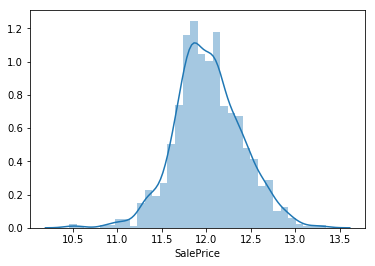

In [12]:
train['SalePrice']=np.log(train['SalePrice'])
sns.distplot(train['SalePrice'])

once again much better

In [13]:
dataset = pd.concat(objs=[train, test], axis=0,sort=False,ignore_index=True)



## Dealing with NaNs and Zeroes:
first lets count number of Nans for each column

In [14]:
dataset.isnull().sum().sort_values(ascending=False)

PoolQC           2850
MiscFeature      2756
Alley            2661
Fence            2294
SalePrice        1459
FireplaceQu      1391
LotFrontage       478
GarageQual        152
GarageYrBlt       152
GarageFinish      152
GarageCond        152
GarageType        150
BsmtExposure       45
BsmtCond           45
BsmtQual           44
BsmtFinType1       42
BsmtFinType2       42
MasVnrType         23
MasVnrArea         22
MSZoning            4
Utilities           2
Functional          2
BsmtFullBath        2
BsmtHalfBath        2
GarageArea          1
BsmtFinSF2          1
Exterior1st         1
TotalBsmtSF         1
GarageCars          1
BsmtUnfSF           1
Electrical          1
BsmtFinSF1          1
KitchenQual         1
SaleType            1
Exterior2nd         1
Street              0
RoofMatl            0
MSSubClass          0
LotArea             0
OverallCond         0
RoofStyle           0
YearRemodAdd        0
YearBuilt           0
OverallQual         0
HouseStyle          0
BldgType  

#### not all 'NANs are missing values
#### According to the "data descriptions" only NANs for LotFrontage,Electrical,GarageCars,GarageArea,MasVnrType , MasVnrArea & SaleType are Actually missing and nothing has been maped to nan
#### we'll deal with them appropiatly 

first we deal with those 4:

## non meaningfull numericals :
we use sklearn SimpleImputer from sklearn  

In [15]:
from sklearn.impute import SimpleImputer
imp_num=SimpleImputer(missing_values=np.nan,strategy='mean') #mean for numericals and mode for categoricals
dataset[['MasVnrArea','LotFrontage','GarageArea']]=pd.DataFrame(imp_num.fit_transform(dataset[['MasVnrArea','LotFrontage'
                                                                                               ,'GarageArea']]))


## Non meaningfull Categorical :

In [16]:
imp_cat=SimpleImputer(missing_values=np.nan,strategy='most_frequent')

dataset[['Electrical','MasVnrType','SaleType','MSZoning','Utilities','Exterior1st','Exterior2nd','BsmtFullBath','BsmtHalfBath','KitchenQual','Functional','SaleType']]=pd.DataFrame(imp_cat.fit_transform(dataset[['Electrical','MasVnrType','SaleType','MSZoning','Utilities','Exterior1st','Exterior2nd','BsmtFullBath','BsmtHalfBath','KitchenQual','Functional','SaleType']]))

## Meaningfull NANS:

In [17]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):  
    dataset[col] = dataset[col].fillna(0)
    
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    dataset[col] = dataset[col].fillna('Nothing')    

In [18]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    dataset[col] = dataset[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    dataset[col] = dataset[col].fillna('Nothing')    

In [19]:
dataset['Alley'] = dataset['Alley'].fillna('Nothing')
dataset['FireplaceQu'] = dataset['FireplaceQu'].fillna('Nothing')
dataset['Fence'] = dataset['Fence'].fillna('Nothing')
dataset['PoolQC']=dataset['PoolQC'].fillna('Nothing')
dataset['MiscFeature']=dataset['MiscFeature'].fillna('Nothing')

In [20]:
import pandas as pd
dataset.isnull().sum().sort_values(ascending=False).head()

SalePrice      1459
Heating           0
RoofStyle         0
RoofMatl          0
Exterior1st       0
dtype: int64

###### ooookay it's done

before jumping into dummy variables: the thing about  pd.get_dummies function is it only recognise categorical datas
for example:MSZoning variables seems to be numerical but each one is actually represnting a categorical variable.but since it 
is numerical in our dataset,get_dummies function won't recognize it and will treat them as numerical hence no dummy column will be created
so what we are going to do is make sure datas are in right type
otherwise there is a lot of ordinal variables that we can use onehot encoding on them

In [21]:
dataset.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1       float64
BsmtFinType2      object
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
Heating           object


'MSSubClass' is categorical variable but it is actually an integer


In [22]:
dataset['MSSubClass']=dataset['MSSubClass'].astype('str')
dataset['MoSold']=dataset['MoSold'].astype('str')


## One Hot Encoding:

In [23]:
#instead of 2006,2007... label them as 0,1 ... for ease in use
from sklearn.preprocessing import LabelEncoder
cat_encoder=LabelEncoder()
print(cat_encoder.fit_transform(dataset['YrSold'].values))
dataset['YrSold']=cat_encoder.fit_transform(dataset['YrSold'].values)


[2 1 2 ... 0 0 0]


## Ordinal Variables:

In [24]:

external=['ExterQual','ExterCond','HeatingQC']
for e in external:
    dataset[e]=dataset[e].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0})
    
    
basement=['BsmtQual','BsmtCond','GarageQual','GarageCond','FireplaceQu','KitchenQual']
for b in basement:
    dataset[b]=dataset[b].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'Nothing':0})
    

dataset['BsmtFinType2']=dataset['BsmtFinType2'].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'Nothing':0})
dataset['BsmtFinType1']=dataset['BsmtFinType1'].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'Nothing':0})
dataset['BsmtExposure']=dataset['BsmtExposure'].map({'Gd':4,'Av':3,'Mn':2,'No':1,'Nothing':0})
dataset['LandSlope']=dataset['LandSlope'].map({'Gtl':2,'Mod':1,'Sev':0})
dataset['Fence']=dataset['Fence'].map({'GdPrv':4,'MnPrv':3,'GdWo':2,'MnWw':1,'Nothing':0})
    


## Creating new functions:
i'm not comfortable with many features for Year
lets create a better feature!

In [26]:
def add_UltimateYear_ix (X):
    UltimateYear_ix = X[:,YearBuilt]+X[:,YearRemodAdd]+X[:,YrSold]
UltimateYear=pd.DataFrame(data={'UltimateYear':dataset['YearBuilt']+dataset['YearRemodAdd']+dataset['YrSold']})
dataset.insert(loc=60,column='UltimateYear',value=UltimateYear)
dataset=dataset.drop(['YearBuilt','YearRemodAdd','YrSold'],axis=1)

### removing some useless variables:

In [27]:
#Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . 
dataset=dataset.drop(['Utilities'],axis=1)
dataset=dataset.drop(['Id'],axis=1) #and drop id column cuase there in no use for it in our model


## lets take a closer look at remainng categorical variables:
since we are smart data scientists we dont want to over complicate our model and since this is relativly large feature dataset 
before to go into dummy variables we are about to see can we get rid of some extra column?so many features can cuase overfitting

In [28]:
for col_name in dataset.columns:
    if dataset[col_name].dtypes=='object':
        unique_cat=len(dataset[col_name].unique())
        print("feature {col_name} has {unique_cat} unique categories".format(col_name=col_name,unique_cat=unique_cat)) #intresting syntax!
        

feature MSSubClass has 16 unique categories
feature MSZoning has 5 unique categories
feature Street has 2 unique categories
feature Alley has 3 unique categories
feature LotShape has 4 unique categories
feature LandContour has 4 unique categories
feature LotConfig has 5 unique categories
feature Neighborhood has 25 unique categories
feature Condition1 has 9 unique categories
feature Condition2 has 8 unique categories
feature BldgType has 5 unique categories
feature HouseStyle has 8 unique categories
feature RoofStyle has 6 unique categories
feature RoofMatl has 7 unique categories
feature Exterior1st has 15 unique categories
feature Exterior2nd has 16 unique categories
feature MasVnrType has 4 unique categories
feature Foundation has 6 unique categories
feature Heating has 5 unique categories
feature CentralAir has 2 unique categories
feature Electrical has 5 unique categories
feature Functional has 7 unique categories
feature GarageType has 7 unique categories
feature GarageFinish has

In [29]:
pd.value_counts(dataset['Exterior1st'],normalize=True).sort_values(ascending=False)*100


VinylSd    35.374388
MetalSd    15.535339
HdBoard    15.255423
Wd Sdng    14.135759
Plywood     7.522743
CemntBd     4.303709
BrkFace     2.729181
WdShing     1.889433
AsbShng     1.469559
Stucco      1.399580
BrkComm     0.174948
Stone       0.069979
CBlock      0.069979
ImStucc     0.034990
AsphShn     0.034990
Name: Exterior1st, dtype: float64

In [30]:
pd.value_counts(dataset['Exterior2nd'],normalize=True).sort_values(ascending=False)*100

VinylSd    35.024493
MetalSd    15.430371
HdBoard    13.995801
Wd Sdng    13.400980
Plywood     9.167250
CmentBd     4.303709
Wd Shng     2.764171
Stucco      1.574528
BrkFace     1.434570
AsbShng     1.294612
Brk Cmn     0.734780
ImStucc     0.489853
Stone       0.139958
AsphShn     0.104969
CBlock      0.104969
Other       0.034990
Name: Exterior2nd, dtype: float64

In [31]:
pd.value_counts(dataset['Neighborhood']).sort_values(ascending=False)

NAmes      429
CollgCr    267
OldTown    237
Somerst    181
Edwards    181
Gilbert    164
NridgHt    158
Sawyer     149
NWAmes     130
SawyerW    120
Mitchel    112
BrkSide    105
Crawfor    103
IDOTRR      92
Timber      71
NoRidge     66
StoneBr     50
SWISU       48
ClearCr     43
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Name: Neighborhood, dtype: int64

In [32]:
pd.value_counts(dataset['MSSubClass']).sort_values(ascending=False)

20     1044
60      569
50      284
120     182
30      139
160     128
70      128
80      118
90       95
190      59
85       47
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

In [33]:
pd.value_counts(dataset['Condition1']).sort_values(ascending=False)

Norm      2463
Feedr      157
Artery      91
RRAn        49
PosN        36
RRAe        27
PosA        20
RRNn         9
RRNe         6
Name: Condition1, dtype: int64

In [34]:
# In this case, bucket low frequecy categories as "Other"
dataset['Exterior1st']=dataset['Exterior1st'].replace(['ImStucc','CBlock','Stone','AsphShn','BrkComm','Stucco','AsbShng','WdShing','BrkFace'],'other')
dataset['Exterior2nd']=dataset['Exterior2nd'].replace(['ImStucc','CBlock','Stone','AsphShn','Brk Cmn','Stucco','AsbShng','WdShing','Other','BrkFace'],'other')
dataset['Neighborhood']=dataset['Neighborhood'].replace(['Blueste','NPkVill','Veenker','Blmngtn','BrDale','MeadowV','ClearCr'],'other')
dataset['MSSubClass']=dataset['MSSubClass'].replace(['150','40','180','45','75'],'other')
dataset['Condition1']=dataset['Condition1'].replace(['RRNe','RRNn','PosA','RRAe','PosN','RRAn'],'other')


## Skwed features:

In [35]:
from scipy.stats import norm, skew
numeric_feats = dataset.dtypes[dataset.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = dataset[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



,Skew
MiscVal,22.118831
PoolArea,18.516507
LowQualFinSF,11.966697
3SsnPorch,11.432982
LotArea,10.369997
KitchenAbvGr,4.566745
BsmtFinSF2,4.154964
EnclosedPorch,4.014800
ScreenPorch,3.932065
BsmtHalfBath,3.896943


#### Box Cox Transformation of (highly) skewed features

We use the scipy function boxcox1p which computes the Box-Cox transformation of  1+x .

Note that setting  λ=0  is equivalent to log1p used above for the target variable.


In [36]:
skewness = skewness[abs(skewness) > 0.75].dropna()
skewness.shape[0]

31

In [37]:
skewness = skewness[abs(skewness) > 0.75].dropna()
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p,inv_boxcox
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    dataset[feat] = boxcox1p(dataset[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 31 skewed numerical features to Box Cox transform


seperating our dataset into train and test and prepare for modeling

In [38]:
train_objs_num = len(train)
dataset_preprocessed = pd.get_dummies(dataset,drop_first=True)
train_preprocessed = dataset_preprocessed[:train_objs_num]
test_preprocessed = dataset_preprocessed[train_objs_num:]

just for shuffling the training set before modeling.that is optional i'll leave it to you(just train,we have to maintain order of test)




In [39]:
#from sklearn.utils import shuffle
#df = shuffle(df)

In [40]:
X_train=train_preprocessed.drop(['SalePrice'],axis=1)
y_train=train_preprocessed['SalePrice']
Test=test_preprocessed.drop(['SalePrice'],axis=1)

In [41]:
X_train.shape

(1399, 202)

## reduce dimensionality:
as smart data scientists we want to achieve best results with minimum complexity.
Such a large set of features can cause overfitting and also slow computing
once again we Use feature selection to select the most important features :

In [42]:
# Such a large set of features can cause overfitting and also slow computing
# Use feature selection to select the most important features
import sklearn.feature_selection

select = sklearn.feature_selection.SelectKBest(k=180)
selected_features = select.fit(X_train, y_train)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [X_train.columns[i] for i in indices_selected]

X_train_selected = X_train[colnames_selected]
X_test_selected = Test[colnames_selected]

C:\Users\Talion\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 98 100 142 148 190] are constant.
  UserWarning)
C:\Users\Talion\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\Talion\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [43]:
(colnames_selected)

['LotFrontage',
 'LotArea',
 'LandSlope',
 'OverallQual',
 'OverallCond',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'FireplaceQu',
 'GarageYrBlt',
 'UltimateYear',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'Fence',
 'MiscVal',
 'MSSubClass_160',
 'MSSubClass_190',
 'MSSubClass_20',
 'MSSubClass_30',
 'MSSubClass_50',
 'MSSubClass_60',
 'MSSubClass_70',
 'MSSubClass_80',
 'MSSubClass_90',
 'MSSubClass_other',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Pave',
 'Alley_Nothing',
 'Alley_Pave',
 'LotShape_I

## Modeling:

In [44]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

# define a cross validation function :

In [45]:
def rmsle(model):   #cross validation for 5 fold
    rmse= np.sqrt(-cross_val_score(model, X_train_selected, y_train, scoring="neg_mean_squared_error",cv =5))
    return(rmse.mean())


# gradient boosting

In [46]:
gb_reg=GradientBoostingRegressor(n_estimators=2000, learning_rate=0.02,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=30, min_samples_split=30, 
                                   loss='huber')
#gb_reg.fit(X_train,y_train);
rmsle(gb_reg)

0.11444376614234367

# RandomForesst:

In [47]:
forest_reg=RandomForestRegressor(n_estimators=200,max_features=14)
forest_reg.fit(X_train,y_train);
rmsle(forest_reg)

0.13659161027021985

## lasso Regression:

In [48]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
rmsle(lasso)

0.11483028104285002

## Elastic Net

In [49]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=3))
rmsle(ENet)

0.11482926461452077

# Kernal Ridge Regression

In [50]:
KRR = KernelRidge(alpha=0.6, kernel='linear', degree=2, coef0=2.5)
rmsle(KRR)

0.11864848773209766

## XGboost

In [51]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
rmsle(model_xgb)

C:\Users\Talion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Talion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Talion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Talion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Talion\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.11804338288089414

## LightGBM :

In [52]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=500,
                              max_bin = 90, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
rmsle(model_lgb)

0.11708369655030429

## BayesianRidge:

In [53]:
br=BayesianRidge()
rmsle(br)

0.11558660445036932

## stacking:

In [54]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [55]:
averaged_models = AveragingModels(models = (ENet, gb_reg, KRR, lasso,model_lgb))

rmsle(averaged_models)

0.11057915793312141

finally for saving your final predictions:

In [ ]:
#averaged_models.fit(X_train,y_train)
#predictions=(averaged_models.predict(Test))
#predictionsdf = pd.DataFrame({'Predictions':np.exp(predictions)})
#predictionsdf.to_csv(r'C:\Users\Talion\Desktop\predictions.csv')